## Welfare Ranges Calculations

### Import simulated scores


In [46]:
import os
import pickle
import copy 
import collections
import warnings
import csv
import platform
import test_simulations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from logging import warning
from operator import concat
from struct import unpack
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18.5 * 0.65, 10.5 * 0.65)

SPECIES = ['pigs', 'chickens', 'carp', 'salmon', 'octopuses', 'shrimp', 'crabs', 'crayfish', 'bees', 'bsf', 'silkworms']

SCENARIO_RANGES = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

params = pickle.load(open(os.path.join('input_data', "Welfare Range Parameters.p"), 'rb'))
NUM_SCENARIOS = params['N_SCENARIOS']
HC_WEIGHT = params['HC_WEIGHT']
WEIGHT_NOS = params['WEIGHT_NOS']

sent_params = pickle.load(open(os.path.join('input_data', 'Sentience Parameters.p'), 'rb'))
SENT_HC_WEIGHT = sent_params['HC_WEIGHT']

# import simulated scores
pig_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_pigs")), 'rb'))
chicken_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_chickens")), 'rb'))
carp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_carp")), 'rb'))
salmon_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_salmon")), 'rb'))
octopus_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_octopuses")), 'rb'))
shrimp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_shrimp")), 'rb'))
crab_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crabs")), 'rb'))
crayfish_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crayfish")), 'rb'))
bee_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bees")), 'rb'))
bsf_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bsf")), 'rb'))
silkworm_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_silkworms")), 'rb'))

unknown_probabilities = pickle.load(open(os.path.join('input_data', "Welfare Range Unknown Probabilities.p"), 'rb'))

overlap_csv = os.path.join('input_data', 'Proxy Overlap.csv')
overlap_dict = {}
with open(overlap_csv) as f:
    reader = csv.reader(f, delimiter=',')
    for idx, rec in enumerate(reader):
        if idx == 0:
            continue
        else:
            sent_proxy = rec[0].strip()
            in_both = rec[1].strip()
            corr_proxy = rec[2].strip()
            if in_both == "y":
                if corr_proxy not in overlap_dict:
                    overlap_dict[corr_proxy] = []
                overlap_dict[corr_proxy].append(sent_proxy)

data = {'pigs': {'Scores': pig_scores, 'FFF': 75, 'Unknown Prob': unknown_probabilities['pigs']}, 
        'chickens': {'Scores': chicken_scores, 'FFF': 50, 'Unknown Prob': unknown_probabilities['chickens']}, 
        'carp': {'Scores': carp_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['carp']}, 
        'salmon': {'Scores': salmon_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['salmon']},
        'octopuses': {'Scores': octopus_scores, 'FFF': 45, 'Unknown Prob': unknown_probabilities['octopuses']}, 
        'shrimp': {'Scores': shrimp_scores, 'FFF': 80, 'Unknown Prob': unknown_probabilities['shrimp']}, 
        'crabs': {'Scores': crab_scores, 'FFF': 14, 'Unknown Prob': unknown_probabilities['crabs']}, 
        'crayfish': {'Scores': crayfish_scores, 'FFF': 55, 'Unknown Prob': unknown_probabilities['crayfish']},
        'bees': {'Scores': bee_scores, 'FFF': 110, 'Unknown Prob': unknown_probabilities['bees']}, 
        'bsf': {'Scores': bsf_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['bsf']}, 
        'silkworms': {'Scores': silkworm_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['silkworms']}}

print(test_simulations.test_wr_scores(data, overlap_dict, HC_WEIGHT, SENT_HC_WEIGHT, SPECIES))

def run_cmd(cmd):
    print(cmd)
    os.system(cmd)

if platform.system() == 'Darwin' or platform.system() == 'Linux':
    run_cmd('rm -rf welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
elif platform.system() == 'Windows':
    run_cmd('rmdir /Q /S welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
else:
    raise ValueError('Platform `{}` not supported'.format(platform.system()))


All proxies with zero/one probabilities have scores equal to their expected values
Number proxies whose proportion was outside 95% CI: 11
Proportion of total proxies whose mean score was outside of the 95% CI: 0.046
Probability of getting > 11/239 proxies outside of their 95% CI: 0.535
Pass Test:
True
rmdir /Q /S welfare_range_estimates
mkdir welfare_range_estimates


## Import Proxies Lists for Each Model


In [47]:
# import proxies lists for each model
model_proxies_df = pd.read_csv(os.path.join('input_data', 'WR Model Proxies.csv'))
# qualitative proxies
qual_proxies_list = model_proxies_df['qualitative'].dropna().values.tolist()
qual_proxies = set()
for proxy in qual_proxies_list:
    if proxy.lower() != "none":
        qual_proxies.add(proxy)

# cubic proxies
cubic_proxies_list = model_proxies_df['cubic'].dropna().values.tolist()
cubic_proxies = set()
for proxy in cubic_proxies_list:
    if proxy.lower() != "none":
        cubic_proxies.add(proxy)

# high-confidence proxies
hc_csv = os.path.join('input_data', 'WR High-Confidence Proxies.csv')
hc_proxies = set()
with open(hc_csv, newline='') as f:
    reader = csv.reader(f)
    hc_proxies_lists = list(reader)
for i, item in enumerate(hc_proxies_lists):
    if i == 0:
        continue
    else:
        hc_proxies.add(item[0])

# qualitative minus social (QMS) proxies
qms_proxies_list = model_proxies_df['qualitative minus social'].dropna().values.tolist()
qms_proxies = set()
for proxy in qms_proxies_list:
    if proxy.lower() != "none":
        qms_proxies.add(proxy)

# pleasure-and-pain-centric (PPC) proxies
ppc_proxies_list = model_proxies_df['pleasure-and-pain-centric'].dropna().values.tolist()
ppc_proxies = set()
for proxy in ppc_proxies_list:
    if proxy.lower() != "none":
        ppc_proxies.add(proxy)

# higher/lower cognitive pleasures (HLP_COG) proxies
hlp_cog_proxies_list = model_proxies_df['higher/lower pleasures - cognitive'].dropna().values.tolist()
hlp_cog_proxies = set()
for proxy in hlp_cog_proxies_list:
    if proxy.lower() != "none":
        hlp_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
hlp_hed_proxies_list = model_proxies_df['higher/lower pleasures - hedonic'].dropna().values.tolist()
hlp_hed_proxies = set()
for proxy in hlp_hed_proxies_list:
    if proxy.lower() != "none":
        hlp_hed_proxies.add(proxy)

# undiluted experience cognitive pleasures (UE_COG) proxies
ue_cog_proxies_list = model_proxies_df['undiluted experience - cognitive'].dropna().values.tolist()
ue_cog_proxies = set()
for proxy in ue_cog_proxies_list:
    if proxy.lower() != "none":
        ue_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
ue_hed_proxies_list = model_proxies_df['undiluted experience - hedonic'].dropna().values.tolist()
ue_hed_proxies = set()
for proxy in ue_hed_proxies_list:
    if proxy.lower() != "none":
        ue_hed_proxies.add(proxy)

## General Code for Generating Welfare Range Distributions (Simple Scoring)

In [48]:

def filter_proxies(species_scores, model_proxies):
    filtered_scores = {}
    for proxy, scores_list in species_scores.items():
        if proxy in model_proxies:
            filtered_scores[proxy] = scores_list
    return filtered_scores

def get_human_sum(model_name, model_proxies, hc_proxies):
    human_sum = 0

    for proxy in model_proxies:
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            human_sum += 1
        else:
            if proxy in hc_proxies:
                human_sum += HC_WEIGHT
            else:
                human_sum += 1
    return human_sum

def one_sim_welfare_range(model_name, f, filtered_scores, sim_idx, fff, human_sum):
    welfare_sum = 0
    for scores_list in filtered_scores.values():
        score_i = scores_list[sim_idx]
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            score_i = score_i/HC_WEIGHT
        welfare_sum += score_i

    adjusted_species_sum = f(welfare_sum)
    adjusted_human_sum = f(human_sum)
    if fff is not None:
        ffr = fff/60
        welfare_range = max(0.28*(adjusted_species_sum/adjusted_human_sum)*ffr + 0.72*(adjusted_species_sum/adjusted_human_sum), 0)
    else: 
        welfare_range = max(adjusted_species_sum/adjusted_human_sum, 0)
    return welfare_range

def one_species_welfare_ranges(model_name, f, species_scores, model_proxies, hc_proxies, fff):
    filtered_scores = filter_proxies(species_scores, model_proxies)
    human_sum = get_human_sum(model_name, model_proxies, hc_proxies)
    
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range(model_name, f, filtered_scores, i, fff, human_sum)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def plot_range_distribution(species, welfare_range_list):
    welfare_range_array = np.array(welfare_range_list)
    plt.hist(welfare_range_array, bins=20, density=True)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[11], color='k', linestyle='dashed', linewidth=1)
    plt.title("Distribution of {} Welfare Ranges".format(species))
    plt.show()
    print('-')

def one_species_summary_stats(species, welfare_range_list, to_print=False):
    welfare_range_array = np.array(welfare_range_list)
    percentiles = np.percentile(welfare_range_array, SCENARIO_RANGES)
    mean = np.mean(welfare_range_array)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    if to_print:
        print("Mean welfare range: {}".format(mean))
        print("5th-percentile welfare range: {}".format(fifth_percentile))
        print("50th-percentile welfare range: {}".format(median))
        print("95th-percentile welfare range: {}".format(ninty_fifth_percentile))
    return stats_tuple

def all_species_welfare_ranges_simple_scoring(f, model_name, data, model_proxies, hc_proxies, SPECIES, to_plot=False):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]
        species_welfare_range_lst = one_species_welfare_ranges(model_name, f, species_scores, model_proxies, hc_proxies, fff_species)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates','{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean", "5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df

    

## Parameters for these Simulations

In [49]:
print("For all the models below, the assumptions are that...")

if WEIGHT_NOS == "Yes":
    print("'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.")
else:
    print("'Likely no's and 'Lean no's are given no probability of being true.")

print("Proxies we're higly confident matter for welfare capacities are given", HC_WEIGHT, "x the weight of other proxies.")

def unknown_probs_df():
    unknown_probs = []
    for species in SPECIES:
        unknown_prob = data[species]["Unknown Prob"]
        unknown_probs.append(unknown_prob)
    cols = ['Unknown Prob.']
    unknowns_df = pd.DataFrame(unknown_probs, columns=cols, index=SPECIES)
    print(unknowns_df) 

unknown_probs_df()


For all the models below, the assumptions are that...
'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.
Proxies we're higly confident matter for welfare capacities are given 5.0 x the weight of other proxies.
           Unknown Prob.
pigs                   0
chickens               0
carp                   0
salmon                 0
octopuses              0
shrimp                 0
crabs                  0
crayfish               0
bees                   0
bsf                    0
silkworms              0


## Qualitative Model

In [50]:
def qual_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qual_wr_stats = all_species_welfare_ranges_simple_scoring(qual_f, "Qualitative", data, qual_proxies, hc_proxies, SPECIES, to_plot=False)


QUALITATIVE
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.662    0.569     0.665     0.747
chickens   0.481    0.412     0.481     0.545
bees       0.442    0.356     0.444     0.522
carp       0.398    0.316     0.400     0.476
octopuses  0.381    0.310     0.381     0.448
salmon     0.295    0.238     0.295     0.347
crayfish   0.229    0.172     0.230     0.284
shrimp     0.193    0.138     0.192     0.246
crabs      0.152    0.110     0.152     0.191
bsf        0.117    0.072     0.117     0.158
silkworms  0.110    0.068     0.113     0.149


## High-Confidence (Simple Scoring)

In [51]:
def ss_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ss_hc_wr_stats = all_species_welfare_ranges_simple_scoring(ss_hc_f, "High-Confidence (Simple Scoring)", data, hc_proxies, hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (SIMPLE SCORING)
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.704    0.581     0.703     0.795
chickens   0.491    0.409     0.490     0.572
bees       0.466    0.352     0.458     0.564
carp       0.422    0.332     0.422     0.513
octopuses  0.402    0.319     0.399     0.478
salmon     0.314    0.241     0.302     0.362
crayfish   0.237    0.167     0.251     0.307
shrimp     0.200    0.125     0.187     0.250
crabs      0.157    0.112     0.157     0.202
bsf        0.121    0.057     0.114     0.171
silkworms  0.107    0.057     0.114     0.143


## Cubic Model

In [52]:
def cubic_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_f, "Cubic", data, cubic_proxies, hc_proxies, SPECIES, to_plot=False)

CUBIC
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.260    0.163     0.259     0.366
chickens   0.126    0.077     0.124     0.180
octopuses  0.067    0.035     0.065     0.106
bees       0.060    0.031     0.059     0.095
carp       0.060    0.029     0.058     0.098
salmon     0.024    0.012     0.024     0.037
crayfish   0.014    0.005     0.013     0.024
shrimp     0.006    0.002     0.006     0.012
crabs      0.006    0.002     0.006     0.011
bsf        0.002    0.000     0.002     0.004
silkworms  0.002    0.000     0.002     0.004


## High-Confidence Proxies (Cubic Model)

In [53]:
def cubic_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

hc_cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_hc_f, "High-Confidence (Cubic)", data, \
    hc_proxies, hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (CUBIC)
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.313    0.171     0.304     0.439
chickens   0.134    0.075     0.130     0.206
octopuses  0.079    0.037     0.073     0.127
carp       0.072    0.033     0.068     0.121
bees       0.070    0.029     0.063     0.118
salmon     0.029    0.013     0.025     0.043
crayfish   0.015    0.005     0.017     0.030
shrimp     0.008    0.002     0.006     0.013
crabs      0.007    0.002     0.006     0.013
bsf        0.002    0.000     0.001     0.005
silkworms  0.002    0.000     0.001     0.003


## Qualitative Minus Social Model

In [54]:
def qms_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qms_wr_stats = all_species_welfare_ranges_simple_scoring(qms_f, "Qualitative Minus Social", data, \
    qms_proxies, hc_proxies, SPECIES, to_plot=False)

QUALITATIVE MINUS SOCIAL
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.671    0.568     0.673     0.767
chickens   0.483    0.405     0.486     0.553
bees       0.454    0.356     0.451     0.547
octopuses  0.413    0.336     0.413     0.484
carp       0.391    0.299     0.392     0.474
salmon     0.299    0.234     0.305     0.357
crayfish   0.230    0.166     0.232     0.287
shrimp     0.211    0.147     0.209     0.265
crabs      0.165    0.117     0.166     0.211
bsf        0.125    0.072     0.124     0.170
silkworms  0.117    0.067     0.121     0.155


## Pleasure-and-pain-centric Model

In [55]:
def ppc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ppc_wr_stats = all_species_welfare_ranges_simple_scoring(ppc_f, "Pleasure-and-pain-centric", data, ppc_proxies, \
    hc_proxies, SPECIES, to_plot=False)

PLEASURE-AND-PAIN-CENTRIC
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.668    0.529     0.662     0.783
carp       0.530    0.381     0.533     0.653
octopuses  0.520    0.403     0.527     0.623
chickens   0.457    0.354     0.462     0.560
salmon     0.424    0.305     0.425     0.523
bees       0.426    0.280     0.420     0.559
crayfish   0.313    0.222     0.322     0.423
shrimp     0.304    0.192     0.304     0.406
crabs      0.240    0.146     0.251     0.308
silkworms  0.138    0.062     0.155     0.216
bsf        0.116    0.052     0.113     0.165


## General Code for Non-Simple Scoring Welfare Ranges


In [56]:
def get_human_sum_2(model_proxies, hc_proxies):
    human_sum = 0

    for proxy in model_proxies:
        if proxy in hc_proxies:
            human_sum += HC_WEIGHT
        else:
            human_sum += 1

    return human_sum

def one_sim_relative_score(filtered_scores, sim_idx, human_sum):
    welfare_sum = 0
    for scores_list in filtered_scores.values():
        score_i = scores_list[sim_idx]
        welfare_sum += score_i

    relative_score = welfare_sum/human_sum
    return relative_score

def one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, sim_idx, fff):
    cog_ratio = one_sim_relative_score(cognitive_scores, sim_idx, human_sum_cog)
    hed_ratio = one_sim_relative_score(hedonic_scores, sim_idx, human_sum_hed)
    prelim_welfare_range = f(cog_ratio, hed_ratio)
    if fff is not None:
        adjusted_welfare_range = max(0.28*prelim_welfare_range*fff/60 + 0.72*prelim_welfare_range, 0)
    else:
        adjusted_welfare_range = max(prelim_welfare_range, 0)
    return adjusted_welfare_range

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, hc_proxies, fff):
    cognitive_scores = filter_proxies(species_scores, cog_proxies)
    hedonic_scores = filter_proxies(species_scores, hed_proxies)
    human_sum_cog = get_human_sum_2(cog_proxies, hc_proxies)
    human_sum_hed = get_human_sum_2(hed_proxies, hc_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, i, fff)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def all_species_welfare_ranges_2(f, model_name, data, cognitive_proxies, hedonic_proxies, hc_proxies, SPECIES, to_plot=False):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]
        species_welfare_range_lst = one_species_welfare_ranges_2(f, species_scores, cognitive_proxies, hedonic_proxies, \
            hc_proxies, fff_species)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean", "5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} - Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df


## Higher/Lower Pleasures Model

In [57]:
def hlp_f(cog_ratio, hed_ratio):
    welfare_range = cog_ratio*hed_ratio
    return welfare_range

hlp_wr_stats = all_species_welfare_ranges_2(hlp_f, "Higher-Lower Pleasures", data, hlp_cog_proxies, \
    hlp_hed_proxies, hc_proxies, SPECIES, to_plot=False)

HIGHER-LOWER PLEASURES
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.386    0.259     0.386     0.513
chickens   0.219    0.147     0.219     0.294
bees       0.127    0.070     0.126     0.188
carp       0.122    0.064     0.120     0.184
octopuses  0.119    0.063     0.117     0.181
salmon     0.067    0.035     0.066     0.098
crayfish   0.030    0.011     0.030     0.050
shrimp     0.023    0.009     0.022     0.039
crabs      0.023    0.009     0.022     0.039
bsf        0.016    0.005     0.017     0.028
silkworms  0.013    0.003     0.012     0.027


## Undiluted Experience Model

In [58]:
def ue_f(cog_ratio, hed_ratio):
    if cog_ratio > 0:
        welfare_range = hed_ratio/cog_ratio
    else:
        welfare_range = hed_ratio/0.01
    return welfare_range

ue_wr_stats = all_species_welfare_ranges_2(ue_f, "Undiluted Experience", data, ue_cog_proxies, \
    ue_hed_proxies, hc_proxies, SPECIES, to_plot=False)

UNDILUTED EXPERIENCE
            Mean  5th-pct  50th-pct  95th-pct
shrimp     2.733    1.250     2.246     5.956
octopuses  1.842    1.170     1.729     2.852
carp       1.500    0.942     1.420     2.306
salmon     1.295    0.852     1.236     1.905
crayfish   1.305    0.709     1.201     2.266
pigs       1.104    0.816     1.079     1.468
silkworms  1.369    0.421     1.076     3.430
crabs      1.163    0.582     1.063     2.060
chickens   0.959    0.693     0.941     1.282
bsf        0.914    0.323     0.865     1.715
bees       0.829    0.492     0.814     1.225


## Mixture Model

In [59]:
import squigglepy as sq

model_results = {'Qualitative': qual_wr_stats, 'High-Confidence Simple Scoring': ss_hc_wr_stats, \
    'Cubic': cubic_wr_stats, 'High-Confidence Cubic': hc_cubic_wr_stats, \
    'Qualitative Minus Social': qms_wr_stats, 'Pleasure-and-pain-centric': ppc_wr_stats, \
    'Higher-Lower Pleasures': hlp_wr_stats, 'Undiluted Experience': ue_wr_stats}

def mixture_one_species(model_results, species, wts):
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    mean = np.mean(dist)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture(model_results, weights):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Qualitative': weights[0], 'High-Confidence (Simple Scoring)': weights[1], \
    'Cubic': weights[2], 'High-Confidence (Cubic)': weights[3], \
    'Qualitative Minus Social': weights[4], 'Pleasure-and-pain-centric': weights[5], \
    'Higher-Lower Pleasures': weights[6], 'Undiluted Experience': weights[7]}

    for species in SPECIES: 
        mix_species = mixture_one_species(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df

mixture = all_species_mixture(model_results, [1/8]*8)


Weights:
{'Qualitative': 0.125, 'High-Confidence (Simple Scoring)': 0.125, 'Cubic': 0.125, 'High-Confidence (Cubic)': 0.125, 'Qualitative Minus Social': 0.125, 'Pleasure-and-pain-centric': 0.125, 'Higher-Lower Pleasures': 0.125, 'Undiluted Experience': 0.125}
Mixture of all Models:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.592    0.220     0.624     1.144
chickens   0.420    0.103     0.444     0.998
bees       0.352    0.047     0.398     0.815
octopuses  0.482    0.054     0.377     1.949
carp       0.439    0.048     0.376     1.592
salmon     0.343    0.019     0.280     1.353
crayfish   0.305    0.010     0.212     1.405
shrimp     0.481    0.004     0.177     3.028
crabs      0.237    0.004     0.143     1.189
bsf        0.170    0.001     0.095     0.856
silkworms  0.245    0.001     0.091     1.401


## Mixture with Neuron Count

In [60]:
neuron_counts = {'pigs': 0.005350, 'chickens': 0.002439, 
                'carp': 0.000160, 'salmon': 0.000160, 
                'octopuses': 0.005407, 'shrimp': 0.000001, 
                'crabs': 0.000001, 'crayfish': 0.000001, 
                'bees': 0.000013, 'bsf': 0.000004, 
                'silkworms': 0.00001}

def mixture_one_species_with_neuron_count(model_results, species, wts):
    # Neuron Count
    neuron_count = neuron_counts[species]
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.uniform(neuron_count, neuron_count), sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture Neuron Count_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    mean = np.mean(dist)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture_with_neuron_counts(model_results, weights):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Neuron Count': weights[0], 'Qualitative': weights[1], 'High-Confidence (Simple Scoring)': weights[2], \
    'Cubic': weights[3], 'High-Confidence (Cubic)': weights[4], \
    'Qualitative Minus Social': weights[5], 'Pleasure-and-pain-centric': weights[6], \
    'Higher-Lower Pleasures': weights[7], 'Undiluted Experience': weights[8]}

    for species in SPECIES: 
        mix_species = mixture_one_species_with_neuron_count(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model Neuron Count - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df


_count = all_species_mixture_with_neuron_counts(model_results, [1/9]*9)

Weights:
{'Neuron Count': 0.1111111111111111, 'Qualitative': 0.1111111111111111, 'High-Confidence (Simple Scoring)': 0.1111111111111111, 'Cubic': 0.1111111111111111, 'High-Confidence (Cubic)': 0.1111111111111111, 'Qualitative Minus Social': 0.1111111111111111, 'Pleasure-and-pain-centric': 0.1111111111111111, 'Higher-Lower Pleasures': 0.1111111111111111, 'Undiluted Experience': 0.1111111111111111}
Mixture of all Models:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.523    0.005     0.589     1.116
chickens   0.373    0.002     0.417     0.974
bees       0.318    0.000     0.373     0.800
octopuses  0.447    0.005     0.356     1.945
carp       0.389    0.000     0.348     1.493
salmon     0.300    0.000     0.260     1.290
crayfish   0.265    0.000     0.190     1.313
shrimp     0.439    0.000     0.156     2.865
crabs      0.219    0.000     0.132     1.171
bsf        0.149    0.000     0.078     0.796
silkworms  0.217    0.000     0.073     1.334


## P(Sentience Adjusted Welfare Ranges)

In [61]:

SPECIES2 = ['pigs', 'chickens', 'carp', 'octopuses', 'bees', 'salmon', 'crayfish', 'shrimp',  'crabs', 'bsf', 'silkworms']

SPECIES_CAPS = ['Pigs', 'Chickens', 'Carp', 'Octopuses', 'Bees', 'Salmon', 'Crayfish', 'Shrimp',  'Crabs', 'Black Soldier Flies', 'Silkworms']

models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
    'Cubic', 'High-Confidence (Cubic)', \
    'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
    'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture", "Mixture Neuron Count"]

def one_species_adj_wr(species, model_name):
    if species != 'shrimp':
        with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))
    else:
        with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))

    with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'rb') as f_wr:
        species_wr = list(pickle.load(f_wr)) 
    species_adj_wr = []

    for i in range(NUM_SCENARIOS):
        psent_i = species_psent[i]
        wr_i = species_wr[i]
        adj_wr_i = max(psent_i*wr_i, 0)
        species_adj_wr.append(adj_wr_i)
    
    return species_adj_wr

import seaborn as sns

def all_species_adj_wr(model_name):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    species_adj_wrs = []

    for species in SPECIES2: 
        wrs_species = one_species_adj_wr(species, model_name)
        species_adj_wrs.append(wrs_species)
        species_stats = one_species_stats(np.array(wrs_species))
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    adj_wr_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES2)
    adj_wr_df = adj_wr_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Summary Statistics.csv".format(model_name))
    adj_wr_df.to_csv(path, index_label="Species")

    return adj_wr_df, species_adj_wrs

import matplotlib.pyplot as plt

def box_plot_adj_wr(model_name, species_adj_wrs, showfliers=True):
    sns.set_style(style='white')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=species_adj_wrs, orient='h', ax=ax, showfliers=showfliers)
    ax.set_yticks([i for i in range(len(SPECIES2))])
    ax.set_yticklabels([SPECIES2[i].capitalize() for i in range(len(SPECIES2))])
    ax.set_title("Preliminary P(Sentience)-Adjusted Welfare Ranges - {} Model".format(model_name))
    fig.savefig(os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Box Plot.png".format(model_name)), dpi=300, bbox_inches='tight')



### Qualitative

Qualitative
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.613    0.469     0.622     0.728
chickens   0.421    0.292     0.429     0.523
octopuses  0.298    0.163     0.300     0.415
bees       0.207    0.016     0.190     0.424
carp       0.181    0.032     0.136     0.383
salmon     0.134    0.022     0.100     0.281
crayfish   0.104    0.018     0.078     0.225
shrimp     0.084    0.015     0.064     0.181
crabs      0.065    0.011     0.050     0.142
bsf        0.035    0.008     0.027     0.076
silkworms  0.009    0.000     0.005     0.028


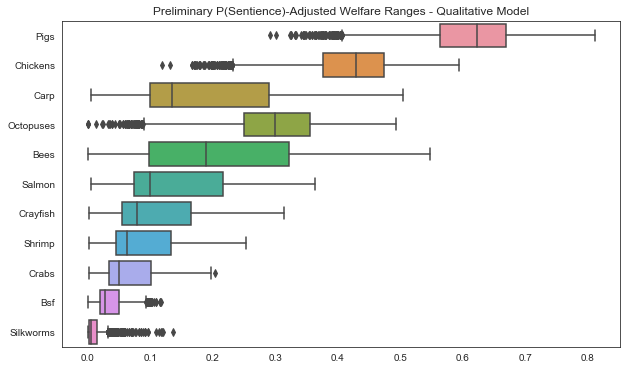

In [62]:
model = "Qualitative"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qual_df, qual_adj_wrs = all_species_adj_wr(model)
print(qual_df)
box_plot_adj_wr(model, qual_adj_wrs)

### High-Confidence Simple Scoring

High-Confidence (Simple Scoring)
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.652    0.492     0.666     0.787
chickens   0.430    0.294     0.433     0.539
octopuses  0.315    0.170     0.316     0.447
bees       0.218    0.017     0.201     0.451
carp       0.192    0.034     0.145     0.414
salmon     0.142    0.024     0.107     0.302
crayfish   0.108    0.018     0.082     0.239
shrimp     0.086    0.015     0.066     0.192
crabs      0.067    0.012     0.052     0.151
bsf        0.036    0.008     0.029     0.081
silkworms  0.009    0.000     0.005     0.028


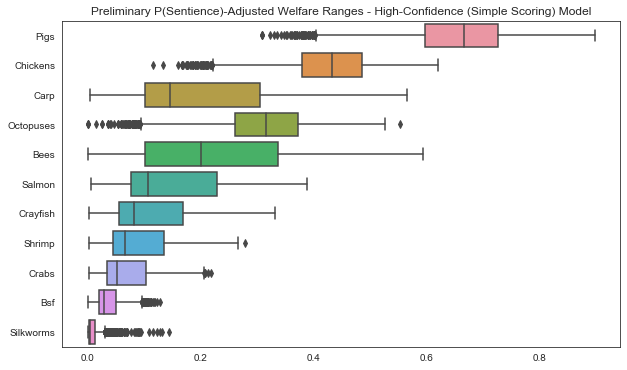

In [63]:
model = "High-Confidence (Simple Scoring)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_ss_df, hc_ss_adj_wrs = all_species_adj_wr(model)
print(hc_ss_df)
box_plot_adj_wr(model, hc_ss_adj_wrs)


### Cubic

Cubic
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.241    0.144     0.236     0.349
chickens   0.111    0.061     0.109     0.166
octopuses  0.053    0.022     0.051     0.089
bees       0.028    0.002     0.025     0.068
carp       0.027    0.004     0.021     0.068
salmon     0.011    0.002     0.009     0.027
crayfish   0.006    0.001     0.005     0.016
shrimp     0.003    0.000     0.002     0.008
crabs      0.003    0.000     0.002     0.007
bsf        0.001    0.000     0.000     0.002
silkworms  0.000    0.000     0.000     0.000


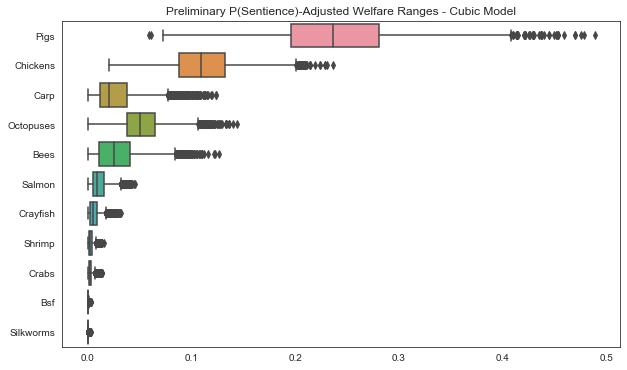

In [64]:
model = "Cubic"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
cubic_df, cubic_adj_wrs = all_species_adj_wr(model)
print(cubic_df)
box_plot_adj_wr(model, cubic_adj_wrs)


### High-Confidence Cubic

High-Confidence (Cubic)
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.290    0.159     0.288     0.434
chickens   0.118    0.058     0.113     0.189
octopuses  0.062    0.023     0.059     0.108
bees       0.033    0.002     0.028     0.082
carp       0.033    0.005     0.025     0.085
salmon     0.013    0.002     0.010     0.034
crayfish   0.007    0.001     0.005     0.020
shrimp     0.003    0.000     0.002     0.010
crabs      0.003    0.000     0.002     0.008
bsf        0.001    0.000     0.000     0.002
silkworms  0.000    0.000     0.000     0.001


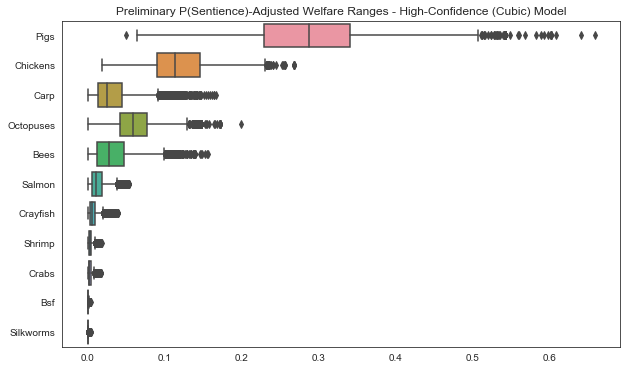

In [65]:
model = "High-Confidence (Cubic)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_cubic_df, hc_cubic_adj_wrs = all_species_adj_wr(model)
print(hc_cubic_df)
box_plot_adj_wr(model, hc_cubic_adj_wrs)


### Qualitative Minus Social

Qualitative Minus Social
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.621    0.470     0.630     0.743
chickens   0.423    0.291     0.429     0.530
octopuses  0.323    0.175     0.325     0.451
bees       0.212    0.017     0.195     0.437
carp       0.177    0.031     0.134     0.380
salmon     0.135    0.023     0.101     0.287
crayfish   0.104    0.018     0.079     0.229
shrimp     0.091    0.016     0.070     0.199
crabs      0.070    0.012     0.054     0.156
bsf        0.037    0.009     0.029     0.082
silkworms  0.010    0.000     0.005     0.030


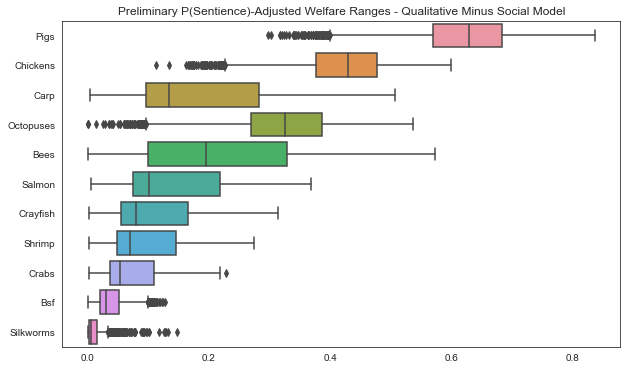

In [66]:
model = "Qualitative Minus Social"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qms_df, qms_adj_wrs = all_species_adj_wr(model)
print(qms_df)
box_plot_adj_wr(model, qms_adj_wrs)


### Pleasure-and-pain-centric

Pleasure-and-pain-centric
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.618    0.454     0.629     0.754
octopuses  0.407    0.220     0.408     0.579
chickens   0.401    0.261     0.405     0.516
bees       0.199    0.015     0.185     0.436
carp       0.240    0.042     0.183     0.523
salmon     0.192    0.032     0.145     0.414
crayfish   0.142    0.024     0.109     0.320
shrimp     0.132    0.023     0.102     0.294
crabs      0.102    0.018     0.080     0.232
bsf        0.035    0.005     0.028     0.085
silkworms  0.011    0.000     0.006     0.038


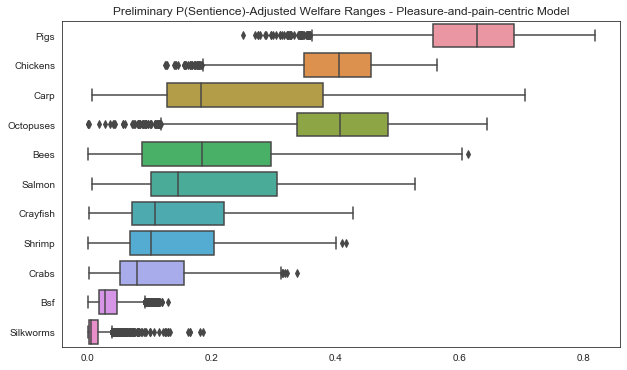

In [67]:
model = "Pleasure-and-pain-centric"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ppc_df, ppc_adj_wrs = all_species_adj_wr(model)
print(ppc_df)
box_plot_adj_wr(model, ppc_adj_wrs)


### Higher-lower Pleasures

Higher-Lower Pleasures
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.357    0.230     0.355     0.494
chickens   0.192    0.114     0.191     0.274
octopuses  0.093    0.039     0.090     0.158
bees       0.059    0.004     0.054     0.137
carp       0.055    0.009     0.043     0.134
salmon     0.030    0.005     0.024     0.072
crayfish   0.013    0.002     0.010     0.035
shrimp     0.010    0.001     0.008     0.026
crabs      0.010    0.001     0.007     0.025
bsf        0.005    0.001     0.004     0.013
silkworms  0.001    0.000     0.001     0.004


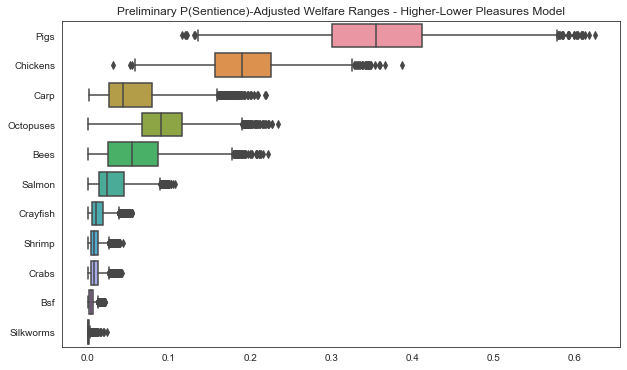

In [68]:
model = "Higher-Lower Pleasures"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hlp_df, hlp_adj_wrs = all_species_adj_wr(model)
print(hlp_df)
box_plot_adj_wr(model, hlp_adj_wrs)


### Undiluted Experience

Undiluted Experience
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
octopuses  1.444    0.680     1.360     2.464
pigs       1.022    0.704     1.002     1.396
chickens   0.839    0.527     0.827     1.185
shrimp     1.185    0.164     0.820     3.080
carp       0.680    0.114     0.511     1.593
salmon     0.585    0.095     0.442     1.352
crayfish   0.594    0.091     0.442     1.457
crabs      0.491    0.078     0.370     1.212
bees       0.387    0.029     0.352     0.870
bsf        0.271    0.037     0.202     0.702
silkworms  0.114    0.002     0.051     0.394


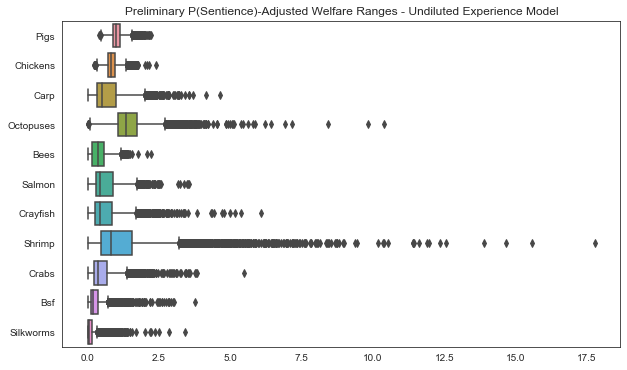

In [69]:
model = "Undiluted Experience"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ue_df, ue_adj_wrs = all_species_adj_wr(model)
print(ue_df)
box_plot_adj_wr(model, ue_adj_wrs)


### Mixture

Mixture
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.548    0.199     0.565     1.069
chickens   0.368    0.086     0.368     0.892
octopuses  0.380    0.037     0.271     1.528
carp       0.199    0.010     0.107     0.716
bees       0.165    0.006     0.100     0.470
salmon     0.157    0.004     0.079     0.602
crayfish   0.137    0.002     0.057     0.591
shrimp     0.210    0.001     0.045     1.222
crabs      0.102    0.001     0.036     0.484
bsf        0.050    0.000     0.019     0.232
silkworms  0.020    0.000     0.003     0.080


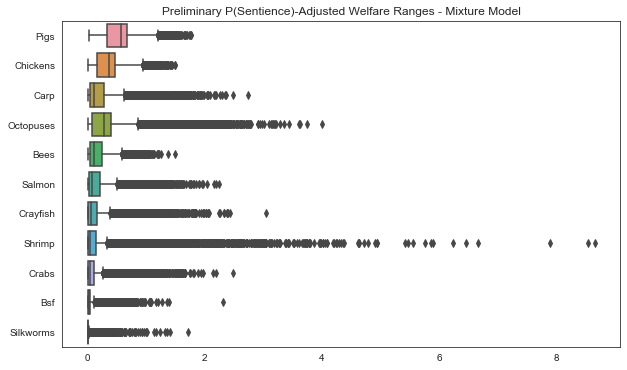

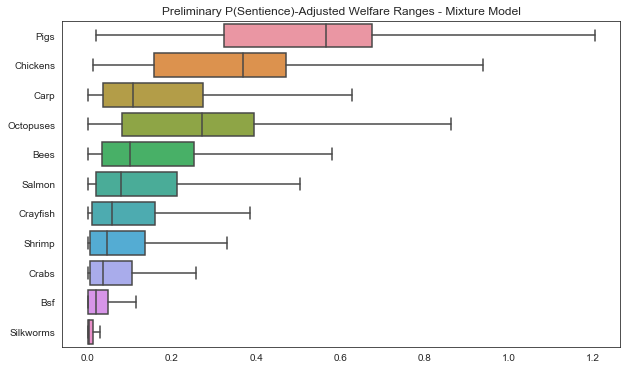

In [70]:
model = "Mixture"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles


## Mixture With Neuron Count Model

Mixture Neuron Count
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       0.484    0.005     0.512     1.031
chickens   0.326    0.002     0.327     0.856
octopuses  0.349    0.004     0.238     1.527
carp       0.175    0.000     0.087     0.590
bees       0.148    0.000     0.071     0.449
salmon     0.136    0.000     0.055     0.495
crayfish   0.119    0.000     0.035     0.503
shrimp     0.190    0.000     0.029     1.095
crabs      0.093    0.000     0.026     0.444
bsf        0.044    0.000     0.014     0.215
silkworms  0.018    0.000     0.001     0.068


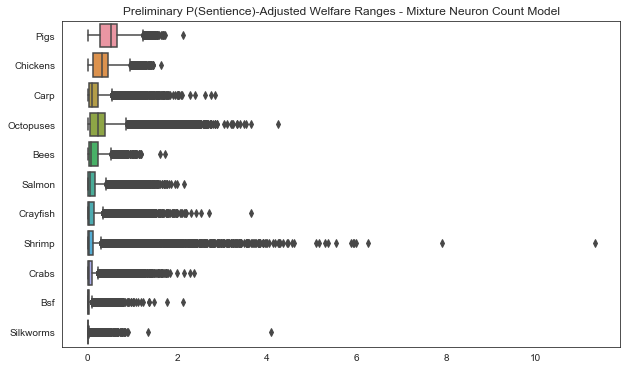

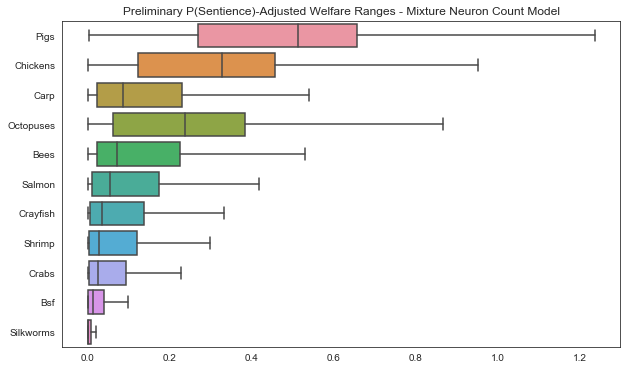

In [71]:
model = "Mixture Neuron Count"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles

## Tests


In [72]:
import unittest
simple_models = {'Qualitative': {"Proxies": qual_proxies, "Function": qual_f}, 
                'High-Confidence (Simple Scoring)': {"Proxies": hc_proxies, "Function": qual_f}, 
                'Cubic': {"Proxies": cubic_proxies, "Function": cubic_f}, 
                'High-Confidence (Cubic)': {"Proxies": hc_proxies, "Function": cubic_f}, 
                'Qualitative Minus Social': {"Proxies": qms_proxies, "Function": qms_f}, 
                'Pleasure-and-pain-centric': {"Proxies": ppc_proxies, "Function": ppc_f}}

proxies = {'qualitative': {'List': qual_proxies_list, 'Set': qual_proxies}, 
            'cubic': {'List': cubic_proxies_list, 'Set': cubic_proxies}, 
            'qualitative minus social': {"List": qms_proxies_list, 'Set': qms_proxies},
            'pleasure-and-pain-centric': {"List": ppc_proxies_list, 'Set': ppc_proxies}, 
            'higher/lower pleasures - cognitive': {'List': hlp_cog_proxies_list, 'Set': hlp_cog_proxies},
            'higher-lower pleasures - hedonic': {'List': hlp_hed_proxies_list, 'Set': hlp_hed_proxies},
            'undiluted experience - cognitive': {'List': ue_cog_proxies_list, 'Set': ue_cog_proxies},
            'undiluted experience - hedonic': {'List': ue_hed_proxies_list, 'Set': ue_hed_proxies}}

complex_models = {'Higher-Lower Pleasures': {"Hedonic Proxies": hlp_hed_proxies, "Cognitive Proxies": hlp_cog_proxies, "Function": hlp_f}, 
                'Undiluted Experience': {"Hedonic Proxies": ue_hed_proxies, "Cognitive Proxies": ue_cog_proxies, "Function": ue_f}}

class TestSimpleFunctions(unittest.TestCase):

    def test_proxies(self):
        pass_test = True
        for model in proxies:
            if set(proxies[model]['List']) != proxies[model]['Set']:
                pass_test = False
        self.assertTrue(pass_test)

    def test_filter_proxies(self):
        pass_test = True
        for model in simple_models:
            model_proxies = simple_models[model]["Proxies"]
            for animal in data.keys():
                animal_scores = data[animal]["Scores"]
                if set(filter_proxies(animal_scores, model_proxies).keys()) != model_proxies:
                    pass_test = False
        self.assertTrue(pass_test)    

    def test_one_sim_wr(self):
        pass_test = True
        for x in [0, 1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in simple_models:
                model_proxies = simple_models[model]['Proxies']
                filtered_scores = filter_proxies(test_scores, model_proxies)

                human_sum = get_human_sum(model, model_proxies, hc_proxies)
                f = simple_models[model]['Function']
                prediction = f(x)
                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range(model, f, filtered_scores, i, 60, human_sum)
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("prediction: {}".format(prediction))
                        print("p: {}".format(p))
        self.assertTrue(pass_test)

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, hc_proxies, fff):
    cognitive_scores = filter_proxies(species_scores, cog_proxies)
    hedonic_scores = filter_proxies(species_scores, hed_proxies)
    human_sum_cog = get_human_sum_2(cog_proxies, hc_proxies)
    human_sum_hed = get_human_sum_2(hed_proxies, hc_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, i, fff)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list
    
class TestComplexFuctions(unittest.TestCase):
    def test_one_sim_relative_score(self):
        pass_test = True
        for x in [0,1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in complex_models:
                for term in {"Hedonic Proxies", "Cognitive Proxies"}:
                    model_proxies = complex_models[model][term]
                    filtered_proxies = filter_proxies(test_scores, model_proxies)
                    human_sum = get_human_sum_2(model_proxies, hc_proxies)
                    prediction = x
                    for i in range(NUM_SCENARIOS):
                        p = one_sim_relative_score(filtered_proxies, i, human_sum)
                        if p != prediction:
                            pass_test = False
                            print("Model: {}".format(model))
                            print("X: {}".format(x))
                            print("Term: {}".format(term))
                            print("Prediction: {}".format(prediction))
                            print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_sim_welare_range_2(self):
        pass_test = True
        for i, x in enumerate([(0.1, 1), (1, 0.1)]): 
            hed_test_scores = {}
            cog_test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    cog_test_scores[proxy] = [x[0]*HC_WEIGHT]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    cog_test_scores[proxy] = [x[0]]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]]*NUM_SCENARIOS

            for model in complex_models:
                human_sum_cog = get_human_sum_2(complex_models[model]["Cognitive Proxies"], hc_proxies)
                human_sum_hed = get_human_sum_2(complex_models[model]["Hedonic Proxies"], hc_proxies)

                cog_model_proxies = complex_models[model]["Cognitive Proxies"]
                cog_proxies = filter_proxies(cog_test_scores, cog_model_proxies)
               
                hed_model_proxies = complex_models[model]["Hedonic Proxies"]
                hed_proxies = filter_proxies(hed_test_scores, hed_model_proxies)
                
                cog_rel_score = one_sim_relative_score(cog_proxies, 0, human_sum_cog)
                hed_rel_score = one_sim_relative_score(hed_proxies, 0, human_sum_hed)

                f = complex_models[model]["Function"]
                prediction = f(cog_rel_score, hed_rel_score)

                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range_2(f, cog_proxies, hed_proxies, human_sum_cog, human_sum_hed, i, 60)
                
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("Prediction: {}".format(prediction))
                        print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_species_wr_2(self):
        pass_test = True
        for x in {1}: 
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS

        for model in complex_models:
            f = complex_models[model]["Function"]
            cog_proxies = complex_models[model]["Cognitive Proxies"]
            hed_proxies = complex_models[model]["Hedonic Proxies"]
            wr_list = one_species_welfare_ranges_2(f, test_scores, cog_proxies, hed_proxies, hc_proxies, 60)
            expect = [1]*NUM_SCENARIOS
            if wr_list != expect:
                pass_test = False
                print("Model: ", model)
                print("Expected: ", expect[0:10])
                print("Actual: ", wr_list[0:10])
        self.assertTrue(pass_test)

class TestMultiplication(unittest.TestCase):
    models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
                'Cubic', 'High-Confidence (Cubic)', \
                'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
                'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture"]
    def test_check_multiplication(self):
        pass_test = True
        
        for model in models: 
            
            for species in SPECIES2:
                if species != 'shrimp':
                    with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                else:
                    with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model)), 'rb') as f_wr:
                    species_wr = list(pickle.load(f_wr)) 
                exp_adj_wrs = []
                for i in range(NUM_SCENARIOS):
                    adj_wr = max(species_psent[i]*species_wr[i],0)
                    exp_adj_wrs.append(adj_wr)
                adj_wr = one_species_adj_wr(species, model)
                if exp_adj_wrs != adj_wr:
                    pass_test = False
        self.assertTrue(pass_test)


res2 = unittest.main(argv=[''], verbosity=3, exit=False)

test_one_sim_relative_score (__main__.TestComplexFuctions) ... ok
test_one_sim_welare_range_2 (__main__.TestComplexFuctions) ... ok
test_one_species_wr_2 (__main__.TestComplexFuctions) ... ok
test_check_multiplication (__main__.TestMultiplication) ... ok
test_filter_proxies (__main__.TestSimpleFunctions) ... ok
test_one_sim_wr (__main__.TestSimpleFunctions) ... ok
test_proxies (__main__.TestSimpleFunctions) ... ok

----------------------------------------------------------------------
Ran 7 tests in 2.075s

OK
